# Lab 06: Gene Expression

---
author: Alex Soja
date: October 18, 2024
embed-resources: true
---

## Introduction

In this report we aim to work towards a proof of concept for a “universal” cancer detection and classification model, given gene expression.

## Methods

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# machine learning
from sklearn.datasets import make_blobs, make_circles
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier


In [2]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

### Data

In [3]:
# load data
cancer_train = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-train.parquet",
)
cancer_test = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-test.parquet",
)
cancer_train

,cancer,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
0,BRCA,0.0,3.149861,1.913454,5.562355,9.638586,0.0,4.302421,0.511670,0.000000,...,7.300691,8.383307,1.187198,0.000000,7.350471,0.0,4.634587,7.082415,9.727447,1.187198
1,LUAD,0.0,6.237034,5.043235,6.297397,10.391415,0.0,7.669941,0.913033,0.000000,...,6.322446,7.815595,13.809095,0.913033,7.651052,0.0,7.476074,4.733739,8.510863,0.000000
2,BRCA,0.0,3.856896,2.394981,6.758277,9.585513,0.0,7.409009,1.242023,0.000000,...,6.845515,9.194823,5.667696,0.000000,7.748253,0.0,5.567421,5.203158,7.364879,0.000000
3,PRAD,0.0,4.279924,3.606963,5.706613,9.716581,0.0,8.244226,0.402613,0.000000,...,6.598611,8.199118,5.024218,0.000000,7.607907,0.0,5.705281,6.278007,9.725383,0.000000
4,BRCA,0.0,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,0.626486,...,7.062651,9.670708,4.243707,0.000000,8.156811,0.0,7.363487,5.384844,8.703443,1.894876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,KIRC,0.0,3.069737,3.623200,6.744955,9.591219,0.0,7.254254,0.000000,0.000000,...,7.333665,8.365334,5.481444,0.000000,7.307674,0.0,5.723447,5.401791,9.067881,0.000000
124,BRCA,0.0,3.534497,3.064866,6.638882,10.010206,0.0,7.899387,0.000000,0.000000,...,7.080615,9.968912,10.501041,0.000000,8.866052,0.0,5.276806,4.941073,8.548240,0.000000
125,BRCA,0.0,4.087463,3.786596,6.385845,9.544964,0.0,8.062856,0.000000,0.000000,...,5.842979,9.931033,10.234817,0.000000,8.384568,0.0,7.033423,5.749534,8.132371,0.000000
126,LUAD,0.0,3.272889,4.529234,7.134909,9.504362,0.0,5.668893,0.000000,0.000000,...,7.300966,8.040350,11.972872,0.000000,7.592607,0.0,5.026256,6.137704,8.780947,1.167936


The underlying source of this data is the The Cancer Genome Atlas Pan-Cancer Analysis Project. The data was accessed via synapse.org.

The specific data for this lab was collected and modified based on a submission to the UCI Irvine Machine Learning Repository.

UCI MLR: Gene Expression Cancer RNA-Seq

### Data Dictionary

# Response

**`cancer`**

- `[object]` the clinically determined cancer type, one of:
  - BRCA: Breast Invasive Carcinoma
  - PRAD: Prostate Adenocarcinoma
  - KIRC: Kidney Renal Clear Cell Carcinoma
  - LUAD: Lung Adenocarcinoma
  - COAD: Colon Adenocarcinoma

# Features

**`gene_`**

- `[float64]` gene expression quantification as measured by an Illumina HiSeq platform.


A summary of our cancer data is given below. We note that the data consisted of five distinct cancer types. Because of this, this dataset is a good start to developing a solid proof of concept for our goal. 

In [14]:
# | echo: false
cancer_counts = cancer_train["cancer"].value_counts()
cancer_proportions = cancer_counts / cancer_counts.sum()
cancer_mix = pd.DataFrame(
    {
        "Cancer Type": cancer_counts.index,
        "Count": cancer_counts.values,
        "Proportion": cancer_proportions.values,
    }
)
(cancer_mix.style.format({"Proportion": "{:.2f}"}).hide(axis="index"))

Cancer Type,Count,Proportion
BRCA,47,0.37
LUAD,28,0.22
PRAD,24,0.19
KIRC,19,0.15
COAD,10,0.08


In our Pairwise Comparison visualization of just the first five genes we can see that our summary above was accurate. The cancer types BRCA and LUAD are the most common and show up the most on the first five genes given. If our model can distinguish the differences between these two common cancer types then our model should show good potential.

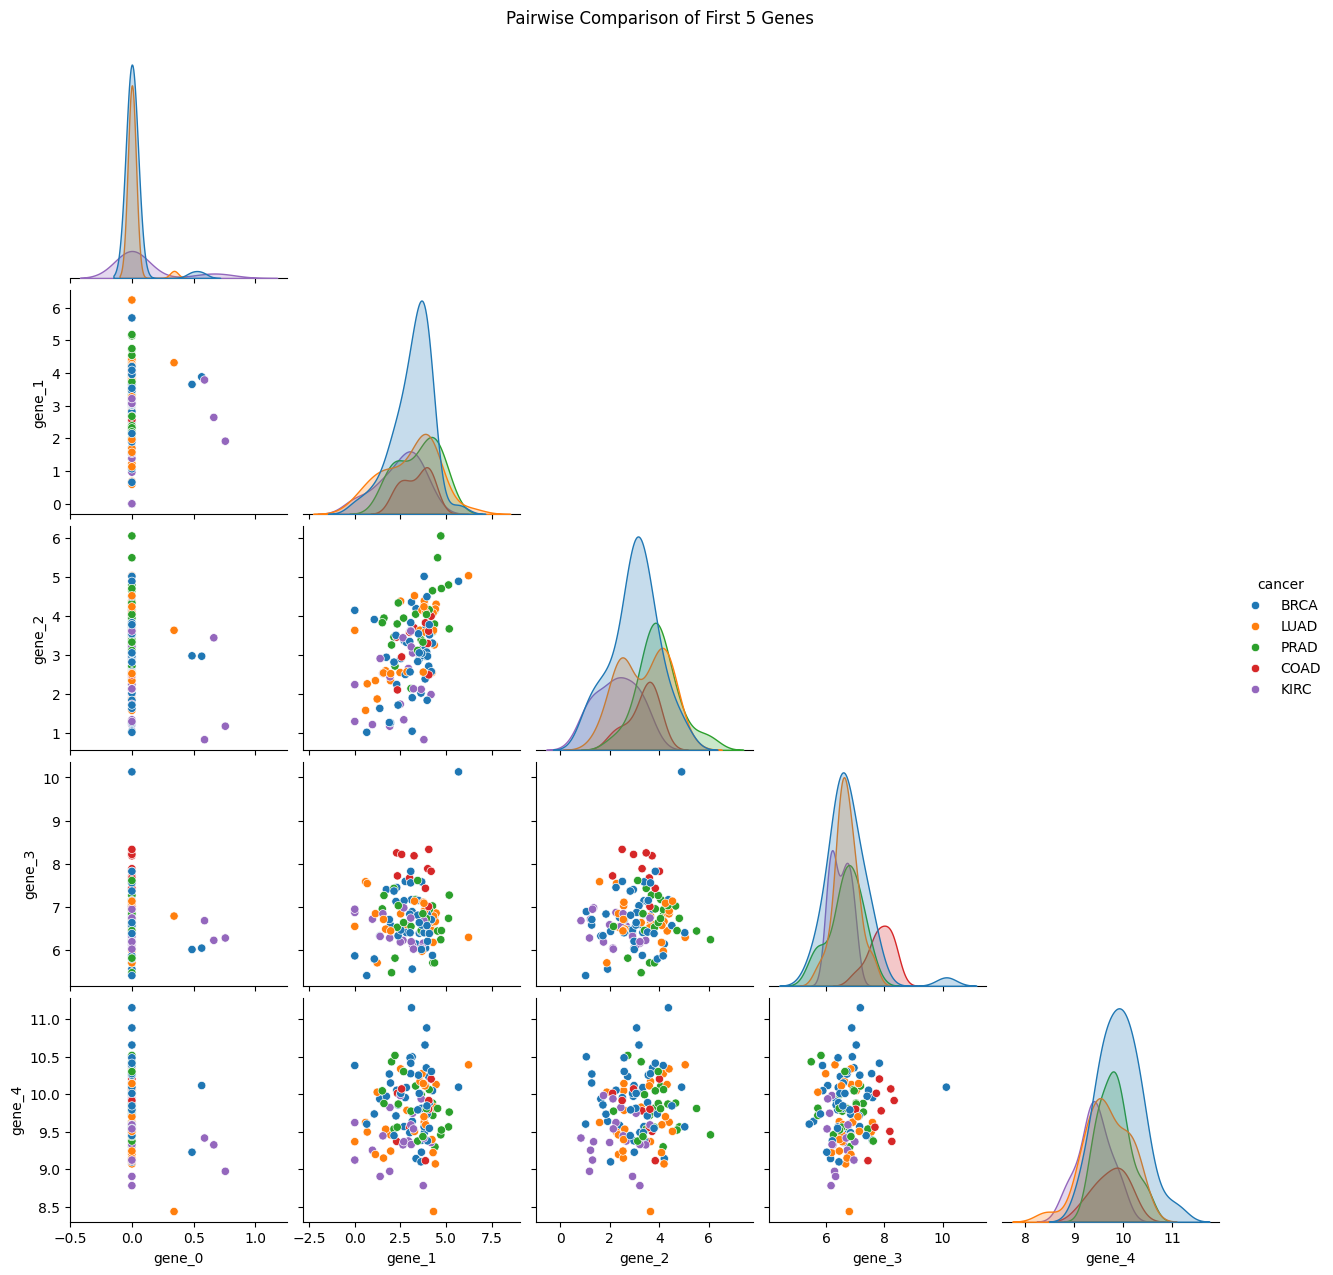

In [16]:
# | echo: false
# visualizations

subset_genes = cancer_train.iloc[:, :6]  # First 5 genes + cancer column

# Create a pairplot
sns.pairplot(data=subset_genes, hue='cancer', corner=True)
plt.suptitle('Pairwise Comparison of First 5 Genes', y=1.02)
plt.show()

### Models

In [6]:
# process data for ML
# create X and y for train
X_train = cancer_train.drop(columns=["cancer"])
y_train = cancer_train["cancer"]

# create X and y for test
X_test = cancer_test.drop(columns=["cancer"])
y_test = cancer_test["cancer"]


To develop a model, we tune a decision tree, dummy classifier, and $k$-nearest neighbors (KNN) models. For these, we consider various values of the available tuning parameters. (See the `param_grid` below.)

All features except for the batters handedness are considered numeric features.

Preprocessing includes imputation (median imputation for numeric and modal imputation for categorical) as well as scaling of numeric features and one-hot-encoding of the categorical feature. For KNN, we also considered unscaled numeric features.

Tuning was performed via cross-validation using a grid-search of the specified parameters. Models were compared using accuracy.

In [7]:
numeric_features = cancer_train.columns[1:].tolist()
categorical_features = cancer_train.columns[:0].tolist()

# preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("Imputer", SimpleImputer(strategy="median")),
        ("Scaling", StandardScaler()),
    ]
)

# preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("Imputer", SimpleImputer(strategy="most_frequent")),
        ("OneHotEncoder", OneHotEncoder()),
    ]
)

# create general preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        (
            "Numeric",
            numeric_transformer,
            numeric_features,
        ),
        (
            "Categorical",
            categorical_transformer,
            categorical_features,
        ),
    ],
    remainder="drop",
)

# create a full pipeline
pipeline = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
        ("Estimator", DummyClassifier()),
    ]
)

# define the parameter grid for grid search
param_grid = [
    {
        "Estimator": [DummyClassifier()],
    },
    {
        "Estimator": [KNeighborsClassifier()],
        "Estimator__n_neighbors": range(1, 101, 2),
        "Preprocessor__Numeric__Scaling": [
            None,
            StandardScaler(),
        ],
    },
    {
        "Estimator": [DecisionTreeClassifier()],
        "Estimator__max_depth": [1, 5, 10, 15, None],
        "Estimator__splitter": ["best", "random"],
    },
]

# setup grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
)

# perform grid search
mod = grid_search.fit(X_train, y_train)

## Results

In [21]:
pprint(grid_search.best_params_)
cv_accuracy = mod.best_score_
print("\n")
print("CV Accuracy:",cv_accuracy)
test_accuracy = mod.score(X_test, y_test)
print("Test Accuracy:",test_accuracy)

{'Estimator': KNeighborsClassifier(),
 'Estimator__n_neighbors': 1,
 'Preprocessor__Numeric__Scaling': None}


CV Accuracy: 0.9923076923076923
Test Accuracy: 1.0


Of the models considered, the best chosen model was a KNeighborsClassifier, with 1 Neighbor, and no preprocessor numeric scaling. 

Based on this chosen model our Cross-Validation Accuracy had a score of about 0.9923, with a Test Accuracy of 1.0.

In [10]:
# | echo: false
# report model metrics
from joblib import dump
dump(mod, "gene-expression.joblib")

['gene-expression.joblib']

## Discussion

We do have to recall that we are only testing with 5 cancer types, this can limit us from creating a "uuniversal detector" but it does put us a step forward nontheless. But regardless our current model is only limited to those 5 cancer types.

In order to establish a more universal model we need to insert more data about more cancer types into our dataset and our model. This is our biggest restriction however because there are numerous types of cancer and new ones are bound to show up in the future. 

### Conclusion

Although our model isn't quite universal just yet, with our current cancer types and accuracy percentages this model is a good proof of concept and achieves our goal. If more cancer types are added in the future I can see this model being put into practice and being used daily.